In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from approval_matrix import plot_approval_matrix
from model_evaluation import cross_val_pr_curve,tune_hyperparameters

In [25]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [26]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':['balanced']
}

best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,RandomForestClassifier(),'average_precision')

print("Best Hyperparameters for RnadomForest Regression:", best_params)


Best Hyperparameters for RnadomForest Regression: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [27]:
# Train RandomForest Regression model with best hyperparameters
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.93706106 0.93768014 0.94035142]
Mean Precision Score: 0.9383642048966099
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      5654
           1       0.89      0.91      0.90     15952

    accuracy                           0.84     21606
   macro avg       0.80      0.79      0.79     21606
weighted avg       0.84      0.84      0.84     21606



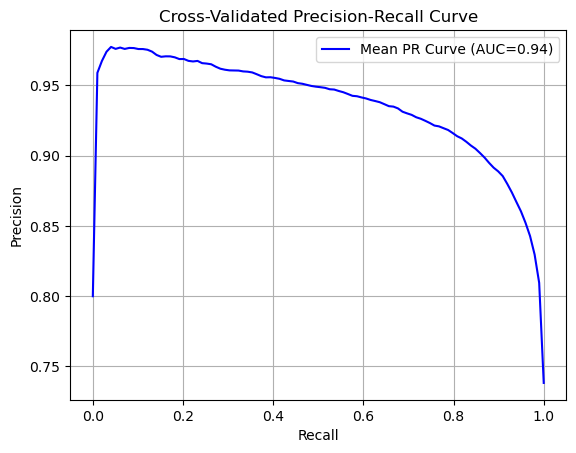

Mean Precision-Recall AUC: 0.9380


In [28]:
from model_evaluation import evaluate_models
evaluate_models(rf_model, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


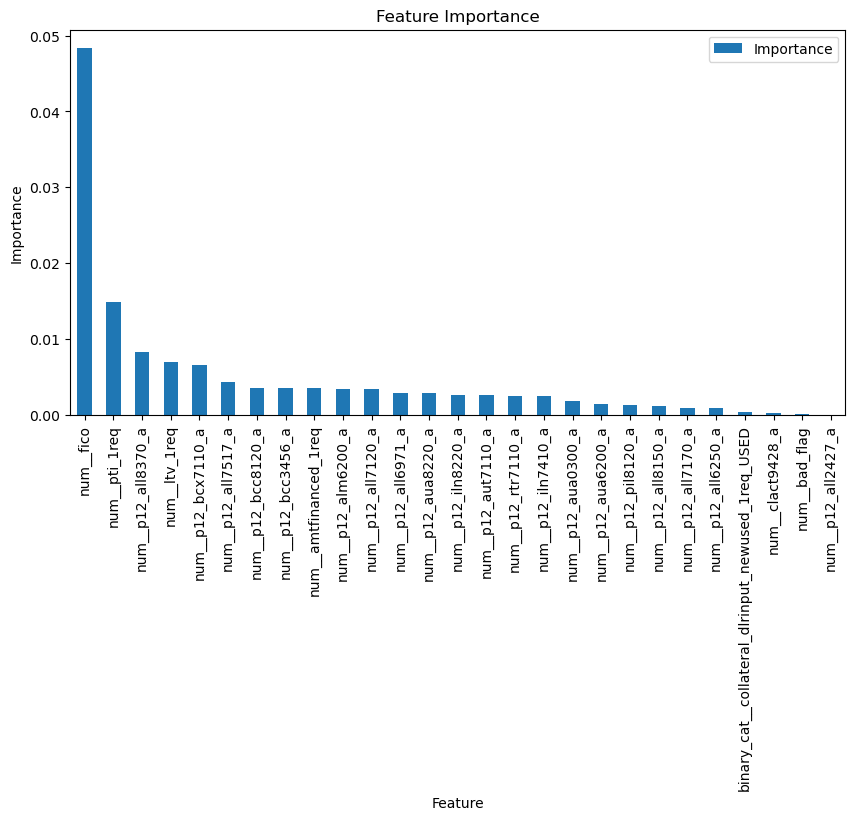

In [29]:
from model_evaluation import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(rf_model, X_train_processed, y_train,'average_precision')

In [30]:
y_pred_rf_test = rf_model.predict(X_test_processed)

### Business Questions

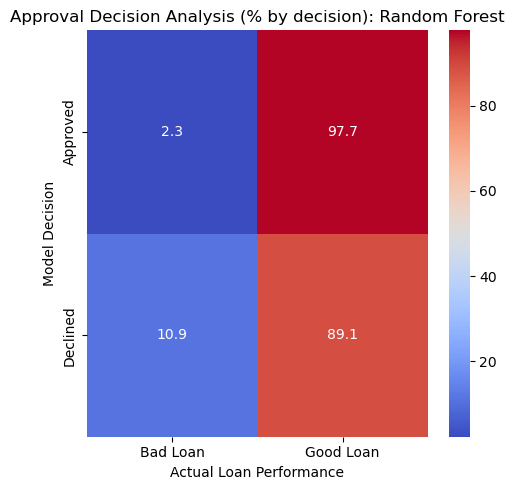

In [31]:
plot_approval_matrix(y_pred_rf_test,X_test_processed['num__bad_flag'], 'Random Forest')

In [32]:
print("Random Forest model approval rate: ", y_pred_rf_test.mean())

Random Forest model approval rate:  0.7479629629629629


In [33]:
gender_aprv = pd.DataFrame({'Gender': pd.read_csv(test_data_path)['Gender'], 'Model_Aprv': y_pred_rf_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.754850,0.737654
Male,0.746258,0.749739
Undefined,0.706564,0.683398


In [34]:
race_aprv = pd.DataFrame({'Race': pd.read_csv(test_data_path)['Race'], 'Model_Aprv': y_pred_rf_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
race_aprv.groupby(['Race']).mean()

,Model_Aprv,True_Aprv
Race,,
Asian,0.776978,0.755396
Black,0.752055,0.724658
Hispanic,0.717781,0.721044
Other,0.710456,0.718499
White,0.762960,0.756480
